In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# Data Collection & Cleaning
df = pd.read_csv(r"C:\Users\Asus\Downloads\full_data_flightdelay.csv\full_data_flightdelay.csv")

# Drop unnecessary columns
cols_to_drop = [
    "DEPARTING_AIRPORT", "PREVIOUS_AIRPORT", "CARRIER_NAME",  
    "LATITUDE", "LONGITUDE", "PRCP", "SNOW", "SNWD", "AWND", 
    "AVG_MONTHLY_PASS_AIRPORT"
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Check missing values
df.dropna(inplace=True)  # Remove rows with missing values


In [3]:
# Categorize DEP_TIME_BLK
def categorize_dep_time(block):
    start_hour = int(block.split('-')[0][:2])  # Extract the starting hour
    if 0 <= start_hour < 6:
        return 'Subuh'
    elif 6 <= start_hour < 12:
        return 'Pagi'
    elif 12 <= start_hour < 18:
        return 'Siang'
    elif 18 <= start_hour < 22:
        return 'Sore'
    else:
        return 'Malam'

df['DEP_TIME_CATEGORY'] = df['DEP_TIME_BLK'].apply(categorize_dep_time)
df = df.join(pd.get_dummies(df['DEP_TIME_CATEGORY'], prefix='DEP_TIME').astype(int)).drop(['DEP_TIME_BLK', 'DEP_TIME_CATEGORY'], axis=1)

df

,MONTH,DAY_OF_WEEK,DEP_DEL15,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRLINE,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,PLANE_AGE,TMAX,DEP_TIME_Malam,DEP_TIME_Pagi,DEP_TIME_Siang,DEP_TIME_Sore,DEP_TIME_Subuh
0,1,7,0,2,1,25,143,13056,107363,5873,13382999,0.000062,0.000099,8,65.0,0,1,0,0,0
1,1,7,0,7,1,29,191,13056,73508,1174,12460183,0.000144,0.000149,3,65.0,0,1,0,0,0
2,1,7,0,7,1,27,199,13056,73508,1174,12460183,0.000144,0.000149,18,65.0,0,1,0,0,0
3,1,7,0,9,1,27,180,13056,73508,1174,12460183,0.000144,0.000149,2,65.0,0,1,0,0,0
4,1,7,0,7,1,10,182,13056,15023,1257,2688839,0.000009,0.000125,1,65.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6489057,12,7,0,1,11,3,123,1318,7268,757,905990,0.000120,0.000198,18,84.0,1,0,0,0,0
6489058,12,7,0,1,11,2,123,1318,7268,757,905990,0.000120,0.000198,16,84.0,0,0,0,1,0
6489059,12,7,0,1,11,2,123,1318,7268,757,905990,0.000120,0.000198,18,84.0,0,0,0,1,0
6489060,12,7,0,1,12,3,123,1318,7268,757,905990,0.000120,0.000198,18,84.0,0,0,0,1,0


In [4]:
# Exploratory Data Analysis
print("Statistical Summary:")
print(df.describe())

Statistical Summary:
              MONTH   DAY_OF_WEEK     DEP_DEL15  DISTANCE_GROUP  \
count  6.489062e+06  6.489062e+06  6.489062e+06    6.489062e+06   
mean   6.607062e+00  3.935598e+00  1.891441e-01    3.821102e+00   
std    3.396853e+00  1.995200e+00  3.916231e-01    2.382233e+00   
min    1.000000e+00  1.000000e+00  0.000000e+00    1.000000e+00   
25%    4.000000e+00  2.000000e+00  0.000000e+00    2.000000e+00   
50%    7.000000e+00  4.000000e+00  0.000000e+00    3.000000e+00   
75%    1.000000e+01  6.000000e+00  0.000000e+00    5.000000e+00   
max    1.200000e+01  7.000000e+00  1.000000e+00    1.100000e+01   

       SEGMENT_NUMBER  CONCURRENT_FLIGHTS  NUMBER_OF_SEATS  \
count    6.489062e+06        6.489062e+06     6.489062e+06   
mean     3.046890e+00        2.783675e+01     1.337397e+02   
std      1.757864e+00        2.151060e+01     4.645213e+01   
min      1.000000e+00        1.000000e+00     4.400000e+01   
25%      2.000000e+00        1.100000e+01     9.000000e+01   
50%

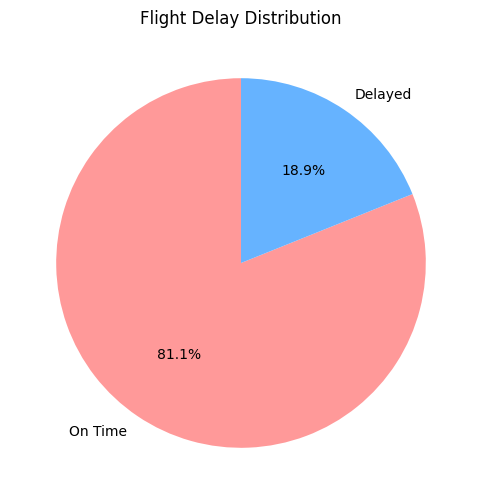

In [5]:
# Pie Chart for Flight Delay Distribution
if 'DEP_DEL15' in df.columns:
    plt.figure(figsize=(6,6))
    df['DEP_DEL15'].value_counts().plot.pie(autopct='%1.1f%%', colors=["#ff9999","#66b3ff"], labels=["On Time", "Delayed"], startangle=90)
    plt.title("Flight Delay Distribution")
    plt.ylabel("")
    plt.show()

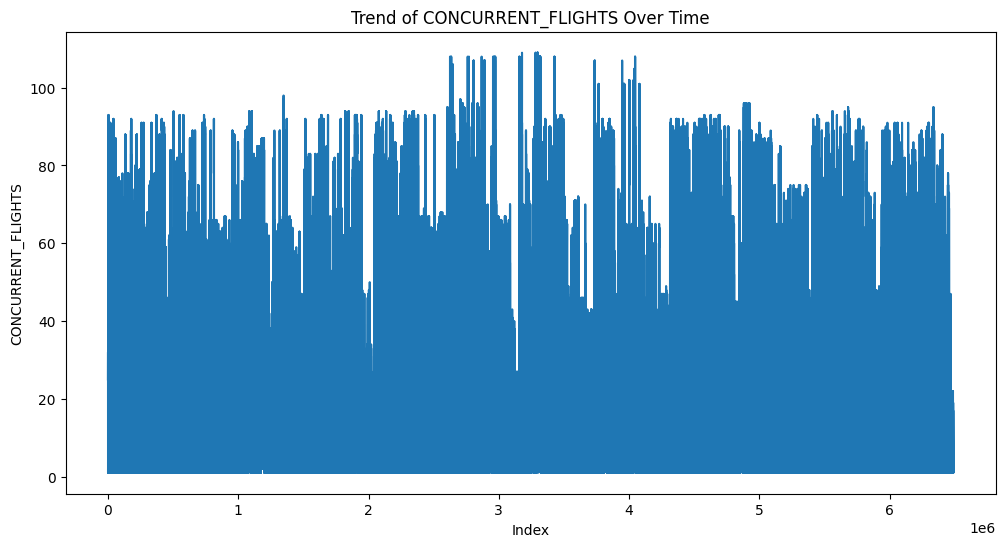

In [6]:
# Trend Analysis
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y=df['CONCURRENT_FLIGHTS'])
plt.xlabel("Index")
plt.ylabel("CONCURRENT_FLIGHTS")
plt.title("Trend of CONCURRENT_FLIGHTS Over Time")
plt.show()

In [7]:
# Define features and target
X, y = df.drop('CONCURRENT_FLIGHTS', axis=1), df.CONCURRENT_FLIGHTS

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
# Train Regression Model with Optimized Hyperparameters
reg = RandomForestRegressor(
    n_estimators=100, 
    max_depth=None,  # Biarkan pohon tumbuh penuh
    min_samples_split=10,  # Biar tidak terlalu banyak splitting kecil
    min_samples_leaf=5,  # Biar setiap leaf minimal punya 5 data
    n_jobs=-1,
    random_state=42
)
reg.fit(X_train, y_train)

# Predict
y_pred = reg.predict(X_test)

In [9]:
# Evaluate Performance
print('R2 Score:', r2_score(y_test, y_pred))
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', math.sqrt(mean_squared_error(y_test, y_pred)))
print('RMSE:', math.sqrt(mean_squared_error(y_test, y_pred)))

R2 Score: 0.879908321226545
Mean Absolute Error (MAE): 4.300313495002277
Root Mean Squared Error (RMSE): 7.455813150605943
RMSE: 7.455813150605943


Top 10 Feature Importances:
AIRPORT_FLIGHTS_MONTH: 0.7999
AIRLINE_AIRPORT_FLIGHTS_MONTH: 0.0292
DISTANCE_GROUP: 0.0198
TMAX: 0.0177
SEGMENT_NUMBER: 0.0154
DAY_OF_WEEK: 0.0146
NUMBER_OF_SEATS: 0.0143
PLANE_AGE: 0.0138
DEP_TIME_Subuh: 0.0132
AIRLINE_FLIGHTS_MONTH: 0.0102


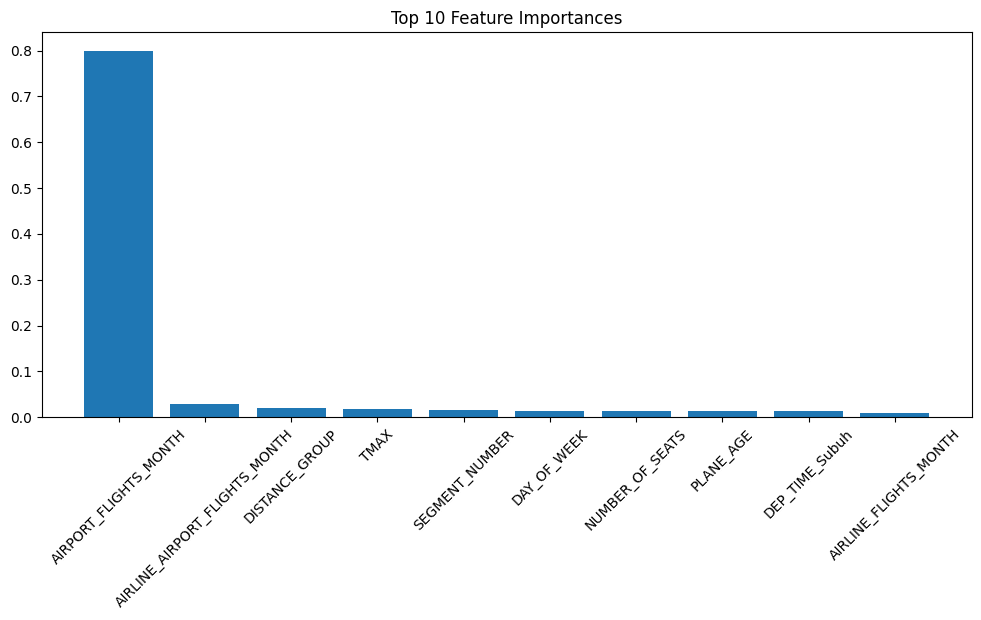

In [10]:
# Feature Importance
importances = dict(zip(X.columns, reg.feature_importances_))
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
print("Top 10 Feature Importances:")
for feature, importance in sorted_importances[:10]:
    print(f"{feature}: {importance:.4f}")

# Plot Feature Importances
plt.figure(figsize=(12, 5))
plt.bar([x[0] for x in sorted_importances[:10]], [x[1] for x in sorted_importances[:10]])
plt.xticks(rotation=45)
plt.title("Top 10 Feature Importances")
plt.show()

In [14]:
sorted_importances

[('AIRPORT_FLIGHTS_MONTH', 0.7999250592251458),
 ('AIRLINE_AIRPORT_FLIGHTS_MONTH', 0.02916160915453616),
 ('DISTANCE_GROUP', 0.019765441437616053),
 ('TMAX', 0.01770704880488421),
 ('SEGMENT_NUMBER', 0.015443966792540507),
 ('DAY_OF_WEEK', 0.014642415063671933),
 ('NUMBER_OF_SEATS', 0.01426237068109234),
 ('PLANE_AGE', 0.013770549954787634),
 ('DEP_TIME_Subuh', 0.01316887965930026),
 ('AIRLINE_FLIGHTS_MONTH', 0.010170623079397438),
 ('DEP_TIME_Malam', 0.010094913524883946),
 ('MONTH', 0.008447045455786468),
 ('DEP_TIME_Pagi', 0.007542405895810469),
 ('AVG_MONTHLY_PASS_AIRLINE', 0.006877845134501778),
 ('DEP_TIME_Sore', 0.0053141887510651286),
 ('GROUND_SERV_PER_PASS', 0.004688542872152908),
 ('FLT_ATTENDANTS_PER_PASS', 0.004103604963423048),
 ('DEP_TIME_Siang', 0.0028465874594721862),
 ('DEP_DEL15', 0.0020669020899317806)]

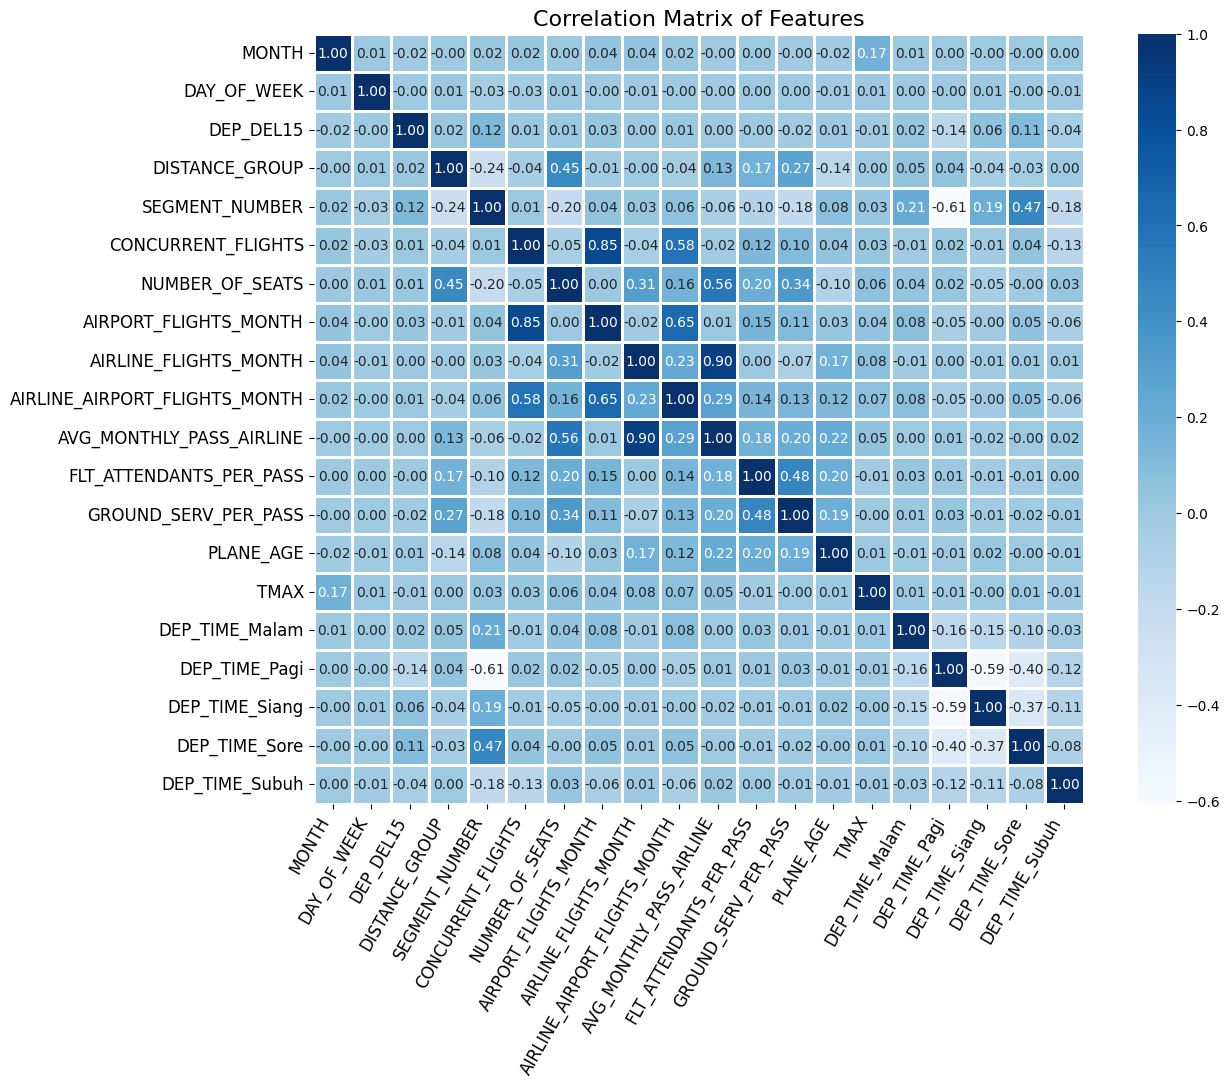

In [11]:
# Heatmap of Correlation Matrix
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="Blues", linewidths=1, annot_kws={"size": 10}, square=True)
plt.xticks(rotation=60, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()

C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


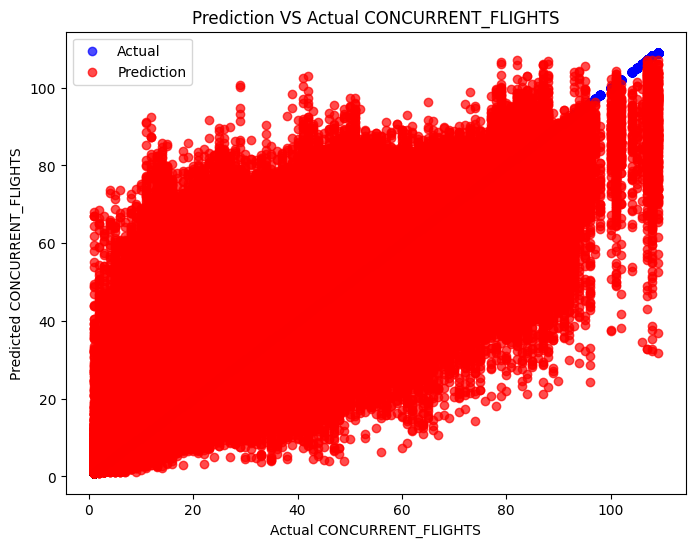

In [12]:
# Visualization - Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test, color='blue', label='Actual', alpha=0.7)
plt.scatter(y_test, y_pred, color='red', label='Prediction', alpha=0.7)
plt.xlabel('Actual CONCURRENT_FLIGHTS')
plt.ylabel('Predicted CONCURRENT_FLIGHTS')
plt.title('Prediction VS Actual CONCURRENT_FLIGHTS')
plt.legend()
plt.show()

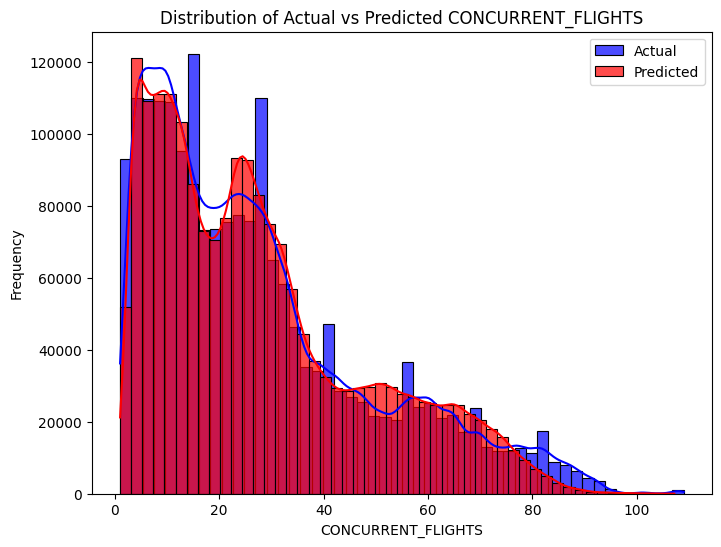

In [13]:
# Distribution of Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.histplot(y_test, bins=50, kde=True, color='blue', alpha=0.7, label='Actual')
sns.histplot(y_pred, bins=50, kde=True, color='red', alpha=0.7, label='Predicted')
plt.xlabel('CONCURRENT_FLIGHTS')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs Predicted CONCURRENT_FLIGHTS')
plt.legend()
plt.show()

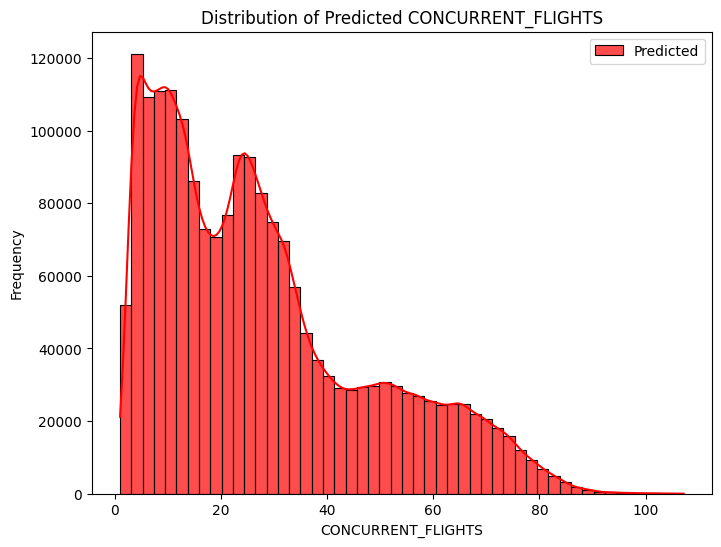

In [ ]:
# Distribution of Predicted
plt.figure(figsize=(8, 6))
sns.histplot(y_pred, bins=50, kde=True, color='red', alpha=0.7, label='Predicted')
plt.xlabel('CONCURRENT_FLIGHTS')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted CONCURRENT_FLIGHTS')
plt.legend()
plt.show()

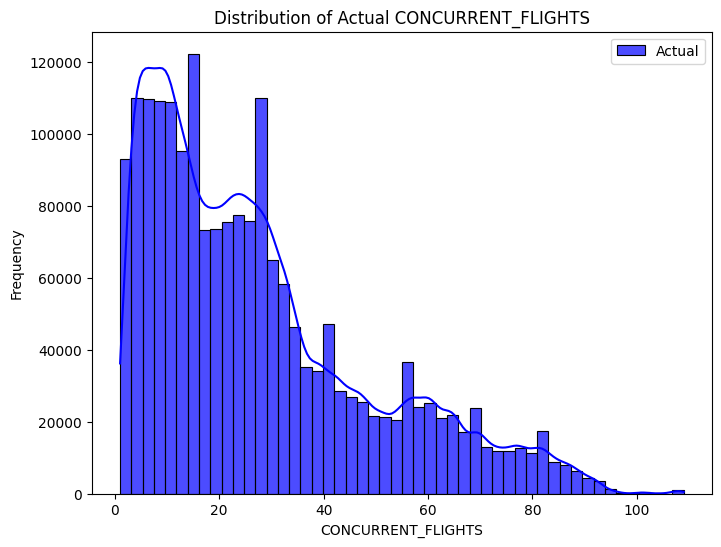

In [ ]:
# Distribution of Actual 
plt.figure(figsize=(8, 6))
sns.histplot(y_test, bins=50, kde=True, color='blue', alpha=0.7, label='Actual')
plt.xlabel('CONCURRENT_FLIGHTS')
plt.ylabel('Frequency')
plt.title('Distribution of Actual CONCURRENT_FLIGHTS')
plt.legend()
plt.show()

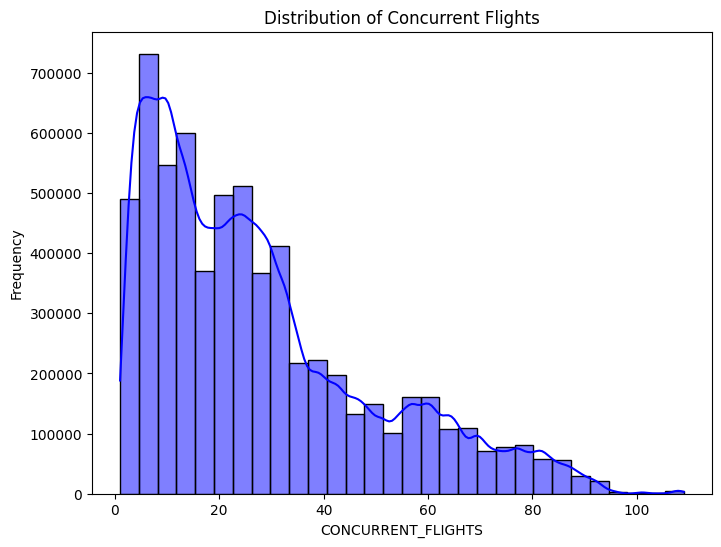

In [17]:
plt.figure(figsize=(8, 6))
sns.histplot(df['CONCURRENT_FLIGHTS'], bins=30, kde=True, color='blue')
plt.xlabel('CONCURRENT_FLIGHTS')
plt.ylabel('Frequency')
plt.title('Distribution of Concurrent Flights')
plt.show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_14492\4271039473.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['DAY_OF_WEEK'], y=df['CONCURRENT_FLIGHTS'], palette="coolwarm")


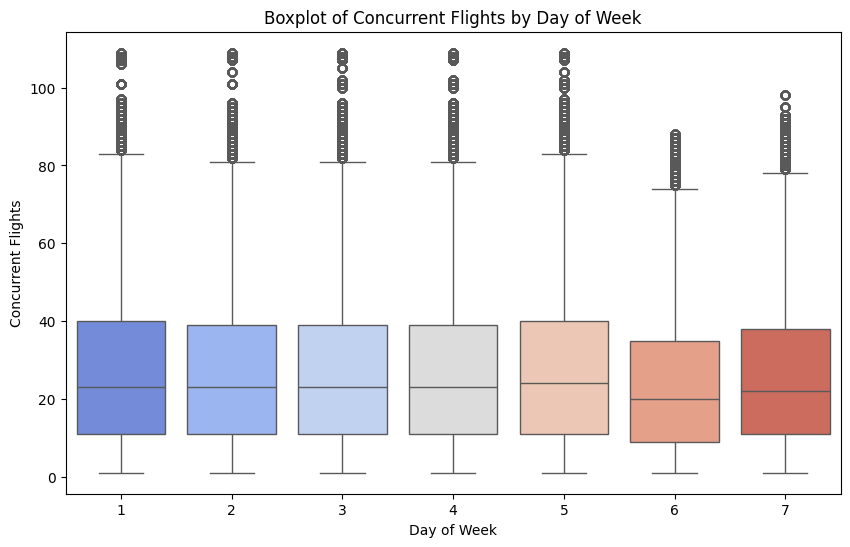

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['DAY_OF_WEEK'], y=df['CONCURRENT_FLIGHTS'], palette="coolwarm")
plt.xlabel("Day of Week")
plt.ylabel("Concurrent Flights")
plt.title("Boxplot of Concurrent Flights by Day of Week")
plt.show()


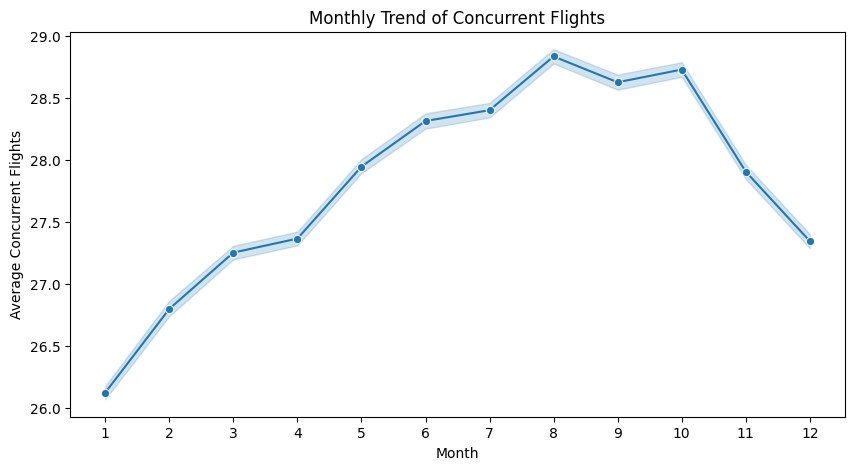

In [19]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=df['MONTH'], y=df['CONCURRENT_FLIGHTS'], marker='o')
plt.xticks(range(1, 13))
plt.xlabel("Month")
plt.ylabel("Average Concurrent Flights")
plt.title("Monthly Trend of Concurrent Flights")
plt.show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_14492\1353891313.py:2: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




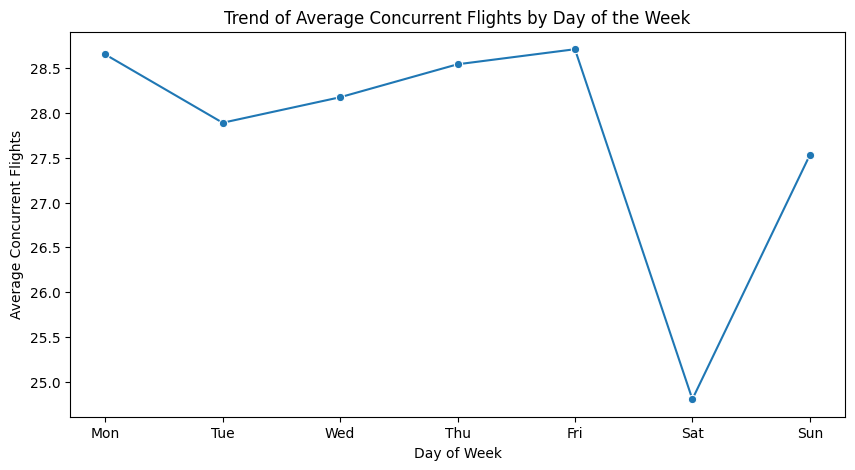

In [38]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=df['DAY_OF_WEEK'], y=df['CONCURRENT_FLIGHTS'], estimator='mean', marker='o', ci=None)
plt.xlabel("Day of Week")
plt.ylabel("Average Concurrent Flights")
plt.title("Trend of Average Concurrent Flights by Day of the Week")
plt.xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])  # Label untuk hari
plt.show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_14492\3279173207.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




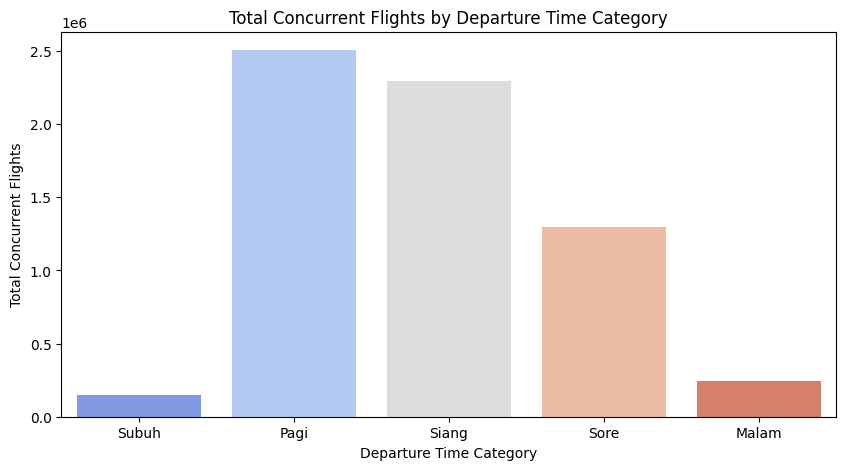

In [39]:
plt.figure(figsize=(10, 5))
sns.barplot(x=['Subuh', 'Pagi', 'Siang', 'Sore', 'Malam'], 
            y=[df['DEP_TIME_Subuh'].sum(), df['DEP_TIME_Pagi'].sum(), 
               df['DEP_TIME_Siang'].sum(), df['DEP_TIME_Sore'].sum(), 
               df['DEP_TIME_Malam'].sum()], 
            palette="coolwarm")
plt.xlabel("Departure Time Category")
plt.ylabel("Total Concurrent Flights")
plt.title("Total Concurrent Flights by Departure Time Category")
plt.show()


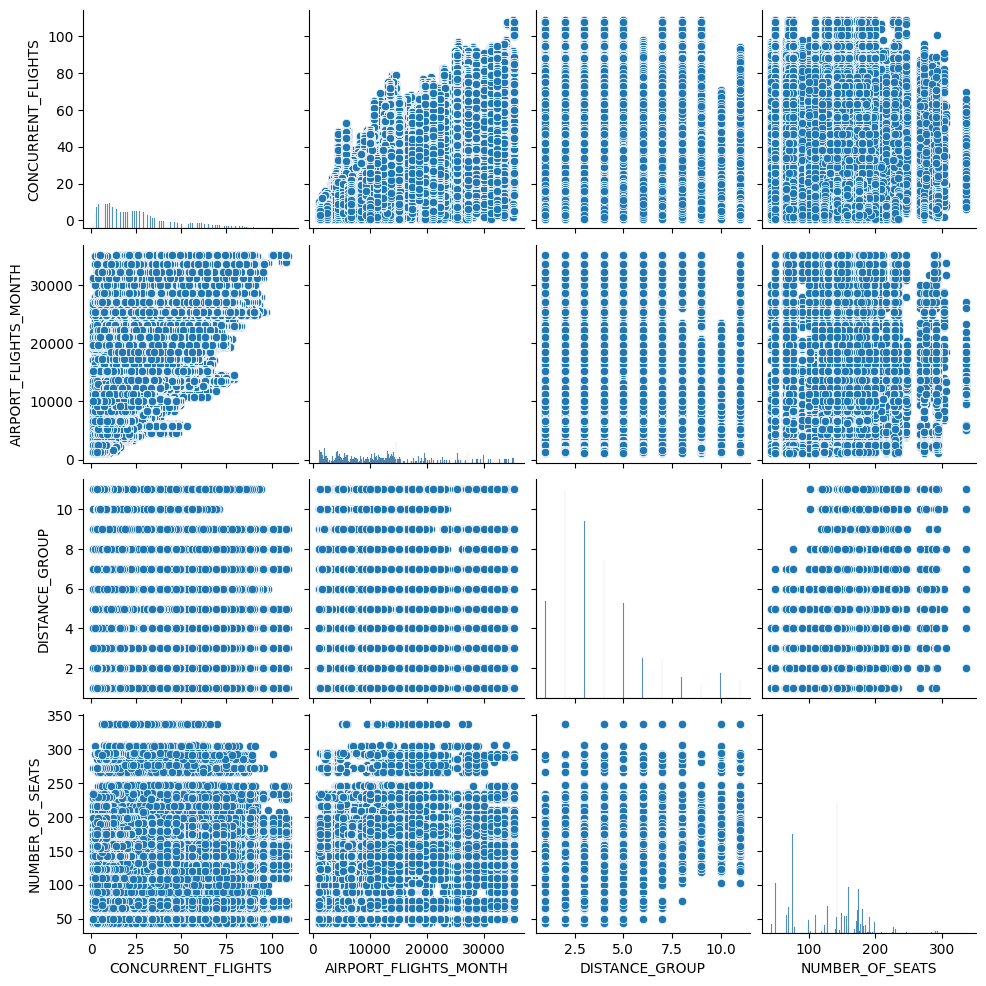

In [28]:
sns.pairplot(df[['CONCURRENT_FLIGHTS', 'AIRPORT_FLIGHTS_MONTH', 'DISTANCE_GROUP', 'NUMBER_OF_SEATS']])
plt.show()


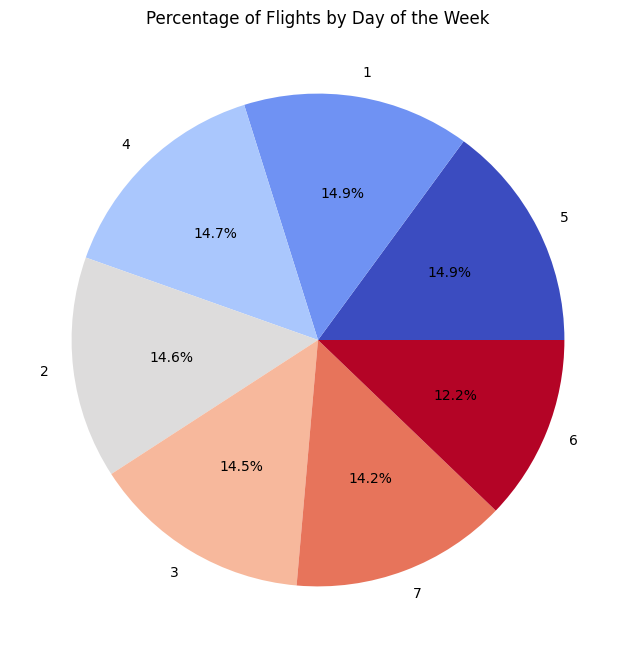

In [33]:
plt.figure(figsize=(8, 8))
df['DAY_OF_WEEK'].value_counts().plot.pie(autopct='%1.1f%%', cmap='coolwarm')
plt.title("Percentage of Flights by Day of the Week")
plt.ylabel("")
plt.show()


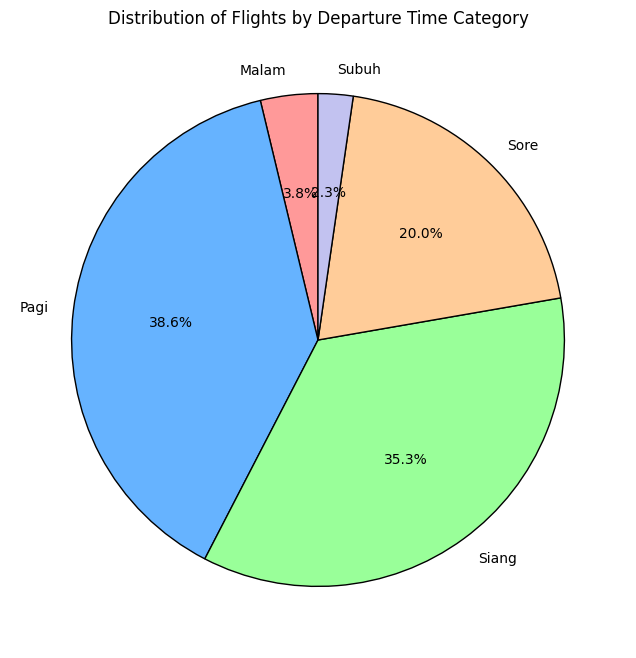

In [36]:
import matplotlib.pyplot as plt

# Hitung total penerbangan per kategori
dep_time_counts = {
    'Malam': df['DEP_TIME_Malam'].sum(),
    'Pagi': df['DEP_TIME_Pagi'].sum(),
    'Siang': df['DEP_TIME_Siang'].sum(),
    'Sore': df['DEP_TIME_Sore'].sum(),
    'Subuh': df['DEP_TIME_Subuh'].sum()
}

# Plot Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(
    dep_time_counts.values(),
    labels=dep_time_counts.keys(),
    autopct='%1.1f%%',
    colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0'],
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Distribution of Flights by Departure Time Category")
plt.show()
